In [1]:
import torch
import torch.utils.data
import pyro
import pyro.infer`
import pyro.optim
import pyro.contrib.autoguide
import matplotlib.pyplot as plt
import numpy as np

# Set-up an estimation problem

$y = a x + b + \epsilon$

where,

$a=2$, $b=3$ and $\epsilon \sim N(0, 3)$

In [2]:
a, b, noise_scale = 2, 3, 3
x = torch.linspace(0, 1, 10000)
eps = noise_scale * torch.randn(*x.shape)
y = a * x + b
yy = y + eps

# Setup a dataset

In [3]:
class Dataset(torch.utils.data.Dataset):
    def __len__(self):
        return len(x)

    def __getitem__(self, idx):
        return x[idx], yy[idx]
dl = torch.utils.data.DataLoader(Dataset(), batch_size=50, shuffle=True)

# Plot

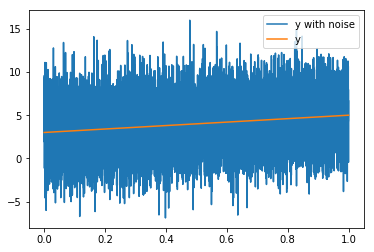

In [4]:
plt.plot(x.numpy(), yy.numpy())
plt.plot(x.numpy(), y.numpy())
plt.legend(['y with noise', 'y'])

# Simple model

The simple model is that we want to estimate just the sensor noise scale

Estimated a=1.973847 (VS 2.000000)
Estimated b=3.011291 (VS 3.000000)
Estimated noise_scale=3.062946 (VS 3.000000)


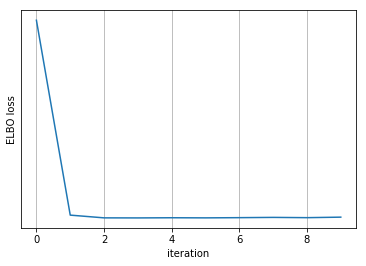

In [5]:
def simple_model(x, y=None): # y=None makes it an unconditioned generative model
    # we want to learn a, initialization does not matter greatly
    a = pyro.param('a', torch.tensor(0.))
    
    # we want to learn b, initialization does not matter greatly
    b = pyro.param('b', torch.tensor(1.0))
    
    # we want to learn noise_scale, initialization does not matter greatly
    noise_scale = pyro.param('noise_scale', torch.tensor(1.),
                             # we want scale to be strictly positive
                             constraint=torch.distributions.constraints.positive) 
    
    # draw a sample from the distribution we want to learn
    pyro.sample('y', pyro.distributions.Normal(a * x + b, noise_scale),
                # y can be observed, so we can learn the parameters
                obs=y)

# I still don't completely get the purpose of guide VS model
# The noop guide seems to work fine, since the model exposes all the necessary info
# i.e. parameters, distributions and observability
def simple_guide(*args):
    pass

loss = pyro.infer.Trace_ELBO()
optimizer = pyro.optim.Adamax({'lr':1e-1})
svi = pyro.infer.SVI(simple_model, simple_guide, optimizer, loss=loss)

pyro.clear_param_store()
losses = []
for epoch in range(10):
    loss = 0
    for X, Y in dl:
        loss += svi.step(X, Y)
    losses.append(loss)

plt.plot(losses)
plt.grid()
plt.yscale('log')
plt.xlabel('iteration')
plt.ylabel('ELBO loss')

print('Estimated a=%f (VS %f)' % (pyro.param('a'), a))
print('Estimated b=%f (VS %f)' % (pyro.param('b'), b))
print('Estimated noise_scale=%f (VS %f)' % (pyro.param('noise_scale'), noise_scale))

# Complex model

We declare our uncertainty over all quantities involved, so, everything becomes a distribution. This is ill-posed. It is my guess that the scale of the noise can leak into the scale of the rest of the dists, since $a$ and $b$ are well estimated. By the way, the model is a bit brittle. It yields nan during optimization sometimes.

Estimated a~N(1.994380, 0.026903) (VS 2.000000)
Estimated b~N(3.029753, 0.027919) (VS 3.000000)
Estimated noise_scale~N(0.000000, 0.044479) (VS 3.000000)


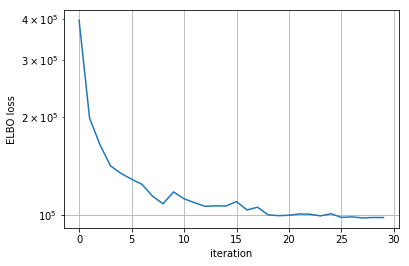

In [6]:
softplus = torch.nn.Softplus()

def complex_model(x, y=None):
    # a
    a_loc = pyro.param('a_loc', torch.tensor(0.))
    a_scale = pyro.param('a_scale', torch.tensor(1.),
                         constraint=torch.distributions.constraints.positive)
    a = pyro.sample('a', pyro.distributions.Normal(a_loc, a_scale))
    
    # b
    b_loc = pyro.param('b_loc', torch.tensor(0.))
    b_scale = pyro.param('b_scale', torch.tensor(1.),
                         constraint=torch.distributions.constraints.positive)
    b = pyro.sample('b', pyro.distributions.Normal(b_loc, b_scale))
    
    # noise_scale
    noise_scale_loc = pyro.param('noise_scale_loc', torch.tensor(0.),
                                 constraint=torch.distributions.constraints.positive)
    noise_scale_scale = pyro.param('noise_scale_scale', torch.tensor(1.),
                                   constraint=torch.distributions.constraints.positive)
    noise_scale = pyro.sample('noise_scale', pyro.distributions.Normal(noise_scale_loc, noise_scale_scale))
    
    # draw a sample
    pyro.sample('y', pyro.distributions.Normal(a * x + b,
                                               # use softplus because noise_scale can be negative
                                               softplus(noise_scale)), obs=y)

                
def complex_guide(*args):
    pass

loss = pyro.infer.Trace_ELBO()
optimizer = pyro.optim.Adamax({'lr':1e-1})
svi = pyro.infer.SVI(complex_model, complex_guide, optimizer, loss=loss)

pyro.clear_param_store()
losses = []
for epoch in range(30):
    loss = 0
    for X, Y in dl:
        loss += svi.step(X, Y)
    losses.append(loss)

plt.plot(losses)
plt.grid()
plt.yscale('log')
plt.xlabel('iteration')
plt.ylabel('ELBO loss')

print('Estimated a~N(%f, %f) (VS %f)' % (pyro.param('a_loc'), pyro.param('a_scale'), a))
print('Estimated b~N(%f, %f) (VS %f)' % (pyro.param('b_loc'), pyro.param('b_scale'), b))
print('Estimated noise_scale~N(%f, %f) (VS %f)' % (pyro.param('noise_scale_loc'), pyro.param('noise_scale_scale'), noise_scale))